In [10]:
# import the necessary packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()
import numpy as np
import os
import glob
import cv2
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

# no.of.trees for Random Forests
num_trees = 100

# bins for histogram
bins = 8

# train_test_split size
test_size = 0.10

# seed for reproducing same results
seed = 9

# num of images per class
images_per_class = 200



In [11]:
# create all the machine learning models
models = []


models.append(('LR', LogisticRegression(random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=9)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=9)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=9)))

# variables to hold the results and names
results = []
names = []

scoring = "accuracy"

# import the feature vector and trained labels
h5f_data = h5py.File('output/data.h5', 'r')
h5f_label = h5py.File('output/labels.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print ("[STATUS] features shape: {}".format(global_features.shape))
print ("[STATUS] labels shape: {}".format(global_labels.shape))

print ("[STATUS] training started...")

[STATUS] features shape: (2400, 532)
[STATUS] labels shape: (2400,)
[STATUS] training started...


In [12]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print ("[STATUS] splitted train and test data...")
print ("Train data  : {}".format(trainDataGlobal.shape))
print ("Test data   : {}".format(testDataGlobal.shape))
print ("Train labels: {}".format(trainLabelsGlobal.shape))
print ("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (2160, 532)
Test data   : (240, 532)
Train labels: (2160,)
Test labels : (240,)


LR: 0.693981 (0.023465)
LDA: 0.719444 (0.018073)
KNN: 0.659722 (0.030021)
CART: 0.725000 (0.020412)
RF: 0.904630 (0.013290)
NB: 0.571759 (0.029005)
SVM: 0.074074 (0.018863)


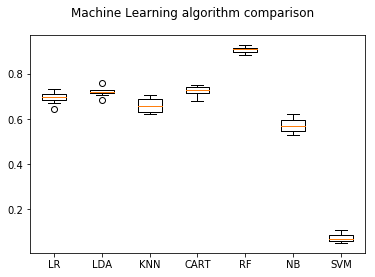

Wall time: 1min 25s


In [13]:
%%time
# filter all the warnings
import warnings
warnings.filterwarnings('ignore')

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [17]:
import mahotas
# feature-descriptor-1: Hu Moments - Quantify shape of flowers
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture - Quantify texture of flowers
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

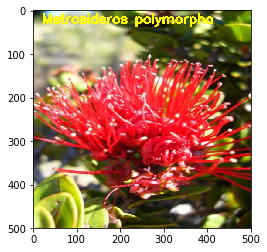

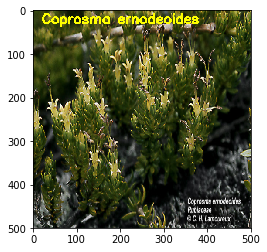

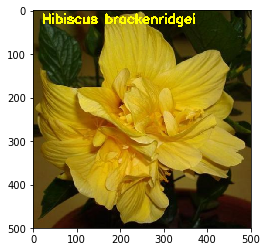

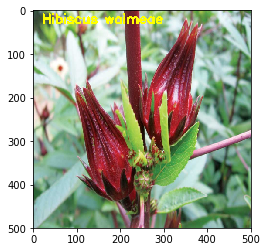

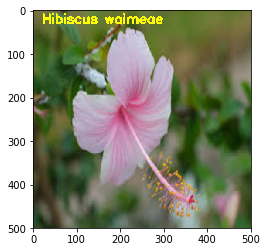

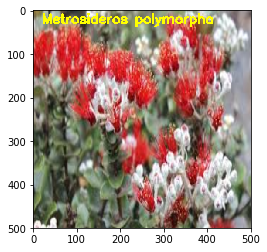

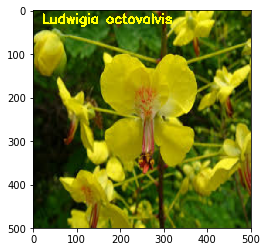

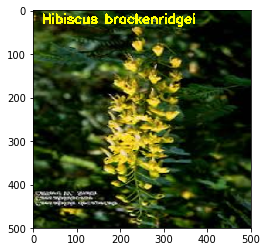

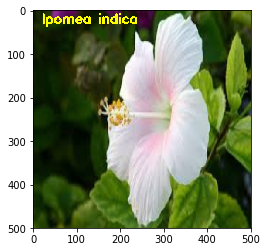

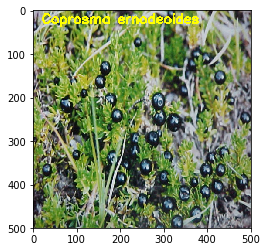

In [19]:
import matplotlib.pyplot as plt

#fixed size for image 
fixed_size = tuple((500,500))

# path to training data
train_path = "jpg"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=100, random_state=9)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)

# path to test data
test_path = "test"

# loop through the test images
for file in glob.glob(test_path + "/*.jpg"):
    # read the image
    image = cv2.imread(file)

    # resize the image
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    # predict label of test image
    prediction = clf.predict(global_feature.reshape(1,-1))[0]

    # show predicted label on image
    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()